# Curve Continuation

<ul id="top">
<li><a href="#Imports"> 
             Imports</a></li>
<li><a href="#Description-of-the-approach"> 
             Description of the approach</a></li>
</ul>

## Imports

In [46]:
using LinearAlgebra
using Plots 
using OrdinaryDiffEq
using Optim

using NLsolve
using BenchmarkTools

include("src/IRK8.jl")
include("src/3body.jl");

# Stuff

In [47]:
chi(z) = [3*z[1], z[2], 0, -2*z[2], -3*z[1], z[2], 
          -z[3]-z[5], -z[4]-z[6], z[3], z[4], z[5], z[6], 0]

function chi!(u0, z) 
    u0[1] = 3*z[1]
    u0[2] = z[2]
    u0[3] = 0
    u0[4] = -2*z[2]
    u0[5] = -3*z[1]
    u0[6] = z[2]
    u0[7] = -z[3]-z[5]
    u0[8] = -z[4]-z[6]
    u0[9] = z[3]
    u0[10] = z[4]
    u0[11] = z[5]
    u0[12] = z[6]
    u0[13] = 0
    return nothing
end


# Suposatuz u egoera bektoreak adierazten duen konfigurazioan hiru gorputzak 
# triangelu isoszelesa osatzen dutela, OX ardatzarekiko simetrikoa dena
# chi_inv(u, T, beta, P) = [u[1]/2, u[2], u[9], u[10], u[11], u[12], T, beta, P] # HONEK EZ DU BALIO KOORDENATU ERLATIBOENTZAT


#function phi(z::Vector{Float64}, odef, p, dt::Float64=0.1)
#    u0 = chi(z)
#    T = z[7]
#    n = Int64(round(T/dt))
#    sol = IRK8(u0, 0., T, 1, n, odef, p)
#    return sol.u[end]
#end

function phi(z::Vector{Float64}, odef, p, dt::Float64=0.1)
    u0 = chi(z)
    T = z[7]
    prob = ODEProblem(odef,u0,(0.,T),p)
    sol=solve(prob,Vern9(), saveat=T,
              adaptive=false,dt=dt)
    return sol.u[end]
end



function g(uT, u0, beta, P)
    (sinb, cosb) = sincos(beta)
    return [uT[1] - cosb*u0[3] + sinb*u0[4],
            uT[2] - sinb*u0[3] - cosb*u0[4],
            uT[3] - cosb*u0[5] + sinb*u0[6],
            uT[4] - sinb*u0[5] - cosb*u0[6],
            uT[7] - cosb*u0[9] + sinb*u0[10],
            uT[8] - sinb*u0[9] - cosb*u0[10],
            ThreeBodyEnergy(u0) + 0.5,
            uT[13] - P]
end

g (generic function with 1 method)

In [48]:
function draw_z(z, odef, p, n, m, iter, title="", triangles=false)
    u0 = chi(z)
    T = z[7] * iter
    return draw(u0, odef, p, 0., T, n, m, title, triangles)
end

draw_z (generic function with 3 methods)

In [76]:
z = [0.296625, -2.663432, 0.632399, 0.001858, -0.632399, 0.001858, 8.703583, -0.005315, 8.682863]

9-element Array{Float64,1}:
  0.296625
 -2.663432
  0.632399
  0.001858
 -0.632399
  0.001858
  8.703583
 -0.005315
  8.682863

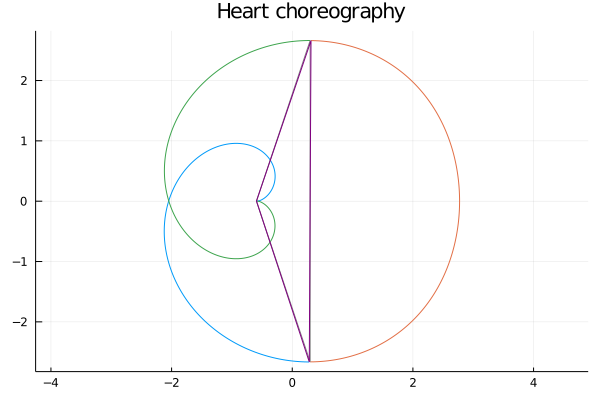

In [80]:
draw_z(z, odef, p, 256, 2, 1, "Heart choreography", true)

test chi, phi and g:

In [74]:
u0 = chi(z)
uT = phi(z, odef, p, 0.01)
z[9] = uT[end]
g(uT, u0, z[8], z[9])

8-element Array{Float64,1}:
 -3.2509890553390723e-13
  9.769962616701378e-15
  1.667554982986985e-13
 -8.881784197001252e-15
 -7.66053886991358e-15
  3.753898233926911e-14
  0.0
  0.0

$f$

In [68]:
struct F3Cor
    odef
    p
    alpha::Vector{Float64}
    z0::Vector{Float64}
    u0::Vector{Float64}
    dt::Float64
end

function F3Cor(odef, p, u, z0, dt::Float64=0.1)
    alpha = similar(z0)
    u0 = similar(u)
    return F3Cor(odef, p, alpha, z0, u0, dt)
end

function (f!::F3Cor)(F, z)
    odef = f!.odef
    p = f!.p
    alpha = f!.alpha
    z0 = f!.z0
    u0 = f!.u0
    dt = f!.dt
    T = z[7] 
    chi!(u0,z)
    beta = z[8]
    P = z[9]
    (sinb, cosb) = sincos(beta)
    F[1] = dot(alpha, z-z0)
    uT = phi(z, odef, p, dt)
    F[2] = uT[1] - cosb*u0[3] + sinb*u0[4]
    F[3] = uT[2] - sinb*u0[3] - cosb*u0[4]
    F[4] = uT[3] - cosb*u0[5] + sinb*u0[6]
    F[5] = uT[4] - sinb*u0[5] - cosb*u0[6]
    F[6] = uT[7] - cosb*u0[9] + sinb*u0[10]
    F[7] = uT[8] - sinb*u0[9] - cosb*u0[10]
    F[8] = ThreeBodyEnergy(u0) + 0.5
    F[9] = uT[13] - P
    return nothing # norm(F[2:end]) # Hau berez ez da beharrezkoa, return nothing izan zitekeen
end

In [82]:
z = [0.296625, -2.663432, 0.632399, 0.001858, -0.632399, 0.001858, 8.703583, -0.005315, 8.682863]
u0 = chi(z)
dt = 0.1
z0 = similar(z)
f! = F3Cor(odef,nothing, u0, z0, dt ) # Datu egitura funtzionala sortu
f!.alpha .= 0
f!.z0 .= 0
f!.alpha[8] = 1
f!.z0[8] = 0 # beta=0

0

In [83]:
F = similar(z)
f!(F, z)
norm(F)

5.306946354230816

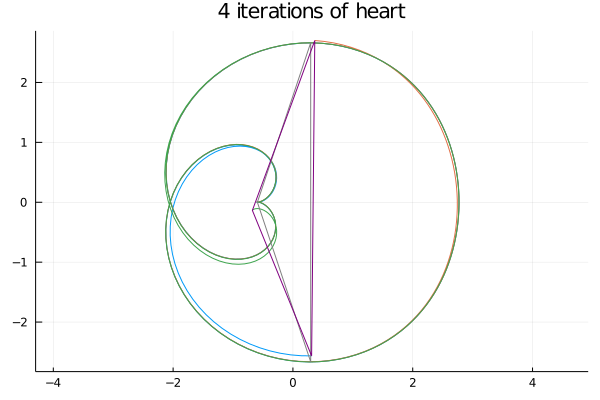

In [84]:
draw_z(z, odef, p, 256, 2, 4, "4 iterations of heart", true)

In [85]:
@time res = nlsolve(f!,z,ftol=1e-12,method=:newton, iterations=10, show_trace=true)
(res.iterations, converged(res))

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.306944e+00              NaN
     1     6.326366e-05     2.835430e+01
     2     1.343705e-09     1.376767e-11
     3     2.864375e-14     6.881848e-18
  0.127312 seconds (1.53 M allocations: 146.831 MiB, 22.17% gc time)


(3, true)

In [88]:
z_new = res.zero;

In [89]:
f!(F, z_new)
norm(F)

3.869457752215254e-14

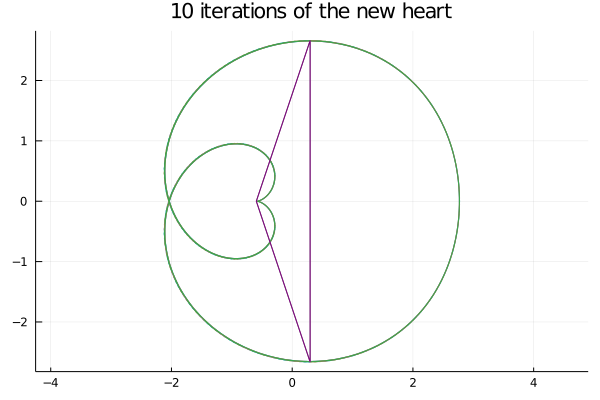

In [91]:
draw_z(z_new, odef, p, 256, 2, 10, "10 iterations of the new heart", true)

# Continuation

In [92]:
#z = [0.297255966633096, -2.6623814891612714, 0.6325352589322643, 0.0020100862792546224, -0.6325352589322646, 0.0020100862792552863, 8.713649084310424, 0.0, 14.007725618542644]
#z = [1.5720920512962908, -1.5941487996419024, 0.3818466846315221, 0.1522878483471256, -0.38184668463230387, 0.15228784834661951, 19.754590365044752, -1.5707963267948966, 27.431539465614193]
#z = [1.2654159885897454, -2.1615981843725405, -0.3683395617781522, 0.13348757451992155, 0.36833956183339156, 0.13348757450064896, 13.396701817330833, 2.867334736682558, 16.72981878957799]
#z = [1.6778977997764128, -0.34138846819636065, -1.1102646446543347, -0.20682644367738676, 1.1102646446543383, -0.20682644367740527, 5.854969536388109, 1.7232674894989781, 8.348936653278471]
z = [1.5730952876277442, -1.2761780586722435, 0.28536136593273337, 0.2704704204756321, -0.2853613659315564, 0.27047042047924325, 13.669357435280828, 0.0, 19.792370239847777]

dbeta = -0.01

# z1 eta z2 lortu
z1 = z

f!.alpha .= 0
f!.alpha[8] = 1
f!.z0 .= z1
f!.z0[8] += dbeta

F = similar(z)
(f!(F, z),  norm(F))
print(F)

res = nlsolve(f!,z1,ftol=1e-8,method=:newton, iterations=10,show_trace=true)

z2 = res.zero
zz = [z1, z2]
# bilaketa egin
ukopmax = 300 # 300
iters0 = 2
iters1 = 4
maxiters = 6
lambda = abs(dbeta)
mu1 = 1.2
mu2 = 1.1
mu3 = 1.2
R = similar(z2)

i=0
cont = true

while cont
    i += 1 
    println(i)
    @. f!.alpha = zz[end] - zz[end-1]
    @. f!.alpha /= norm(f!.alpha)
    @. f!.z0 = zz[end] + f!.alpha * lambda
#    z00 = copy(f!.z0)
    z00 = zz[end]   
    res = nlsolve(f!,z00,ftol=1e-8,method=:newton, iterations=maxiters, show_trace=true)
    iters = res.iterations
    if converged(res)
        push!(zz, res.zero)
        println("T=", res.zero[7], ", beta=", res.zero[8],
                ", lambda=", lambda, ", it=", res.iterations, ", normres=", f!(R,res.zero))
        (iters <= iters0) ? lambda *=mu1 : nothing
        (iters >= iters1) ? lambda /=mu2  : nothing
    else
        lambda /= mu3
    end
    cont = (i < ukopmax) && sign(zz[end][8])==sign(zz[end-1][8])
end

[0.01, 1.4531299537790492e-12, -3.185007813044649e-12, 2.0801138589376933e-12, -5.917488721252084e-13, -4.3787196091216174e-13, -6.959988141375106e-13, -3.774758283725532e-15, 4.583000645652646e-13]Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.000000e-02              NaN
     1     1.588563e-04     1.645748e-03
     2     1.515756e-08     1.189200e-09
     3     3.286260e-14     6.844718e-14
1
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     2.682403e-04     2.791378e-03
     2     4.356755e-08     2.401843e-09
     3     6.560030e-14     1.134292e-13
T=13.620027438238782, beta=-0.023041018685741273, lambda=0.01, it=3, normres=nothing
2
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     2.671297e-04     2.788972e-03
     2     4.472643e-08     2.340931e-09
     3     7.137346e-1

     0     9.000000e-02              NaN
     1     3.784095e-04     2.702038e-03
     2     9.687311e-08     2.838229e-09
     3     1.276756e-13     3.302121e-13
T=12.9701342389739, beta=-0.3381471597069215, lambda=0.01, it=3, normres=nothing
26
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     3.882478e-04     2.696631e-03
     2     1.086465e-07     3.070654e-09
     3     1.758593e-13     3.554658e-13
T=12.943632072354193, beta=-0.3513090736677445, lambda=0.01, it=3, normres=nothing
27
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     3.989838e-04     2.691063e-03
     2     1.224370e-07     3.368885e-09
     3     2.415845e-13     3.842317e-13
T=12.917143924310029, beta=-0.3644664140139846, lambda=0.01, it=3, normres=nothing
28
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9

     4     9.597752e-08     1.356435e-08
     5     1.180611e-12     1.668331e-13
T=12.341660816852205, beta=-0.6047919835343478, lambda=0.00573921028466483, it=5, normres=nothing
50
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.695718e-02              NaN
     1     1.883685e-02     2.246863e-03
     2     1.174711e-02     1.834462e-03
     3     7.170358e-02     1.127858e-02
     4     1.974597e-02     3.198256e-03
     5     1.187174e-02     1.703707e-03
     6     3.877017e+00     5.520724e+00
51
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.913098e-02              NaN
     1     1.306074e-02     1.560322e-03
     2     1.066095e-02     1.664838e-03
     3     1.777216e-02     2.863184e-03
     4     8.830127e-03     1.419846e-03
     5     8.068420e+00     7.418153e+00
     6              NaN     1.135551e+03
52
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   ------------

┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/markel/.julia/packages/DiffEqBase/znIav/src/integrator_interface.jl:348
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/markel/.julia/packages/DiffEqBase/znIav/src/integrator_interface.jl:348
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/markel/.julia/packages/DiffEqBase/znIav/src/integrator_interface.jl:348
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/markel/.julia/packages/DiffEqBase/znIav/src/integrator_interface.jl:348
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/markel/.julia/packages/DiffEqBase/znIav/src/integrator_interface.jl:348
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/markel/.julia/packages/DiffEqBase/znIav/src/integrator_interface.jl:348
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/markel/.julia/packages/DiffEqBase/znIav/src/integrator_interface.jl:348
┌ Warning: Instability detected. Aborting
└ @ DiffEqBas

     1     9.058673e-03     1.083557e-03
     2     1.074152e-02     1.679067e-03
     3     8.052056e-03     1.312095e-03
     4     1.752424e-02     2.807256e-03
     5     7.362276e-03     1.241387e-03
     6     5.977083e-02     9.003348e-03
53
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.717429e-02              NaN
     1     6.284468e-03     7.524699e-04
     2     1.304578e-02     2.043993e-03
     3     5.639247e-03     9.311598e-04
     4     6.838413e-02     1.027802e-02
     5     1.728294e-02     2.664830e-03
     6     7.180776e-03     1.002401e-03
54
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.264524e-02              NaN
     1     4.360704e-03     5.225486e-04
     2     2.400136e-02     3.781312e-03
     3     7.122863e-03     1.224216e-03
     4     4.380688e-03     6.448368e-04
     5     3.943514e-02     6.270266e-03
     6     1.063639e-02     1.934162e-03
55
Iter     f(

     2     1.040010e-08     4.733544e-09
     3     1.798561e-14     2.020968e-16
T=12.31091051125103, beta=-0.5862479786515127, lambda=0.0009192540519195281, it=3, normres=nothing
76
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.273286e-03              NaN
     1     5.380601e-05     2.687047e-05
     2     8.807561e-09     4.077452e-09
T=12.310430842431193, beta=-0.5846793131469605, lambda=0.0009192540519195281, it=2, normres=nothing
77
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.927944e-03              NaN
     1     7.361043e-05     3.961856e-05
     2     1.544531e-08     7.284162e-09
     3     2.842171e-14     4.151665e-16
T=12.309984147212647, beta=-0.5827684233128276, lambda=0.0011031048623034337, it=3, normres=nothing
78
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.927944e-03              NaN
     1     6.943319e-05     4.070458e-05
 

     1     7.231717e-05     1.591765e-04
     2     1.445572e-08     2.341774e-09
     3     7.460699e-14     1.493168e-16
T=12.33063048184982, beta=-0.5226489467334021, lambda=0.0022873982424723997, it=3, normres=nothing
101
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.058658e-02              NaN
     1     6.826160e-05     1.584774e-04
     2     1.228335e-08     2.040960e-09
     3     8.437695e-15     1.163806e-16
T=12.333088274752114, beta=-0.5189049777498131, lambda=0.0022873982424723997, it=3, normres=nothing
102
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.058658e-02              NaN
     1     6.460301e-05     1.578501e-04
     2     1.051189e-08     1.792552e-09
     3     2.842171e-14     9.297018e-17
T=12.335621760879471, beta=-0.5151729874265818, lambda=0.0022873982424723997, it=3, normres=nothing
103
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   -------------

     3     1.172396e-13     8.178066e-15
T=12.46599142370907, beta=-0.37764497997932894, lambda=0.005691778794708921, it=3, normres=nothing
125
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.122601e-02              NaN
     1     1.771134e-04     9.380816e-04
     2     1.032789e-08     5.227179e-09
     3     1.492140e-13     7.473195e-15
T=12.47598174195273, beta=-0.36887065800651014, lambda=0.005691778794708921, it=3, normres=nothing
126
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.122601e-02              NaN
     1     1.780076e-04     9.379906e-04
     2     9.648906e-09     4.782261e-09
T=12.48610085450385, beta=-0.36011115450420056, lambda=0.005691778794708921, it=2, normres=nothing
127
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.147121e-02              NaN
     1     2.578583e-04     1.350701e-03
     2     1.878710e-08     9.055515e-09


     1     2.552965e-04     1.367280e-03
     2     1.100473e-08     2.259118e-09
     3     1.669775e-13     6.274401e-15
T=12.787546535810947, beta=-0.1323523379077079, lambda=0.006830134553650705, it=3, normres=nothing
149
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.147121e-02              NaN
     1     2.547575e-04     1.368288e-03
     2     1.087672e-08     2.161980e-09
     3     1.820766e-14     5.954710e-15
T=12.802455805463156, beta=-0.12210833843253309, lambda=0.006830134553650705, it=3, normres=nothing
150
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     6.147121e-02              NaN
     1     2.542099e-04     1.369290e-03
     2     1.073749e-08     2.071861e-09
     3     6.039613e-14     5.656519e-15
T=12.817448947120159, beta=-0.1118710839865946, lambda=0.006830134553650705, it=3, normres=nothing
151
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------

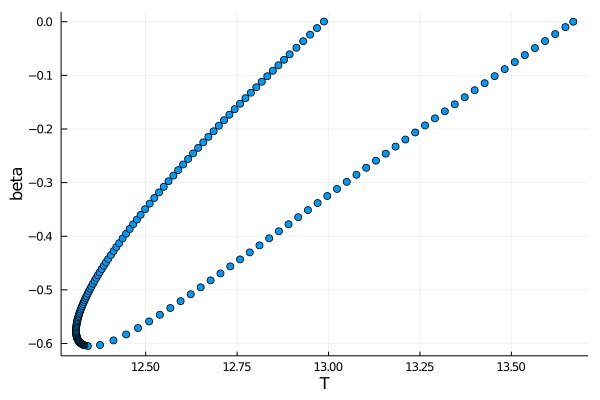

In [96]:
TT = [z[7] for z in zz]
bb =  [z[8] for z in zz]
scatter(TT,bb, legend=false, xlabel="T", ylabel="beta")

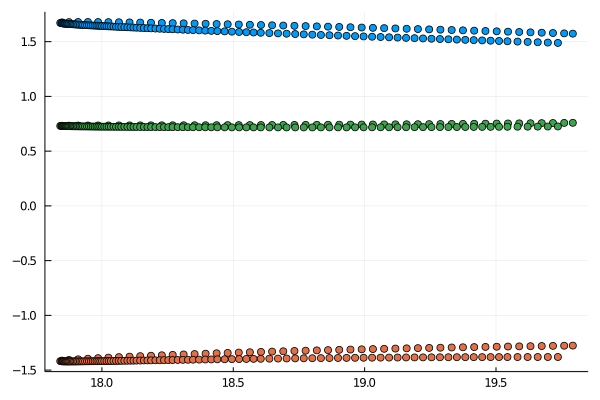

In [98]:
PP = [z[9] for z in zz]
xx2 = [z[1] for z in zz]
yy2 = [z[2] for z in zz]
gg2 = [atan(z[4],z[3]) for z in zz]
scatter(PP,xx2, legend=false)
scatter!(PP,yy2)
scatter!(PP,gg2)

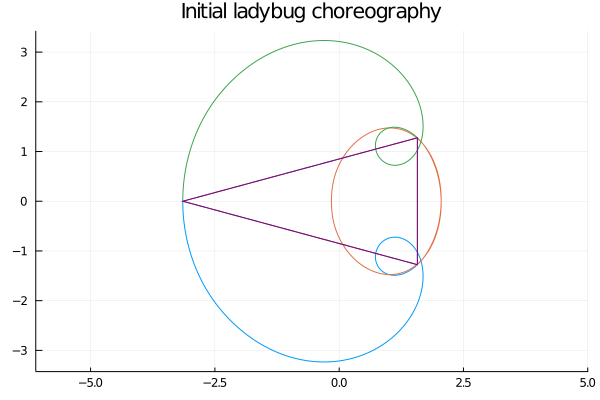

In [104]:
draw_z(zz[1], odef, p, 256, 2, 1, "Initial ladybug choreography", true)

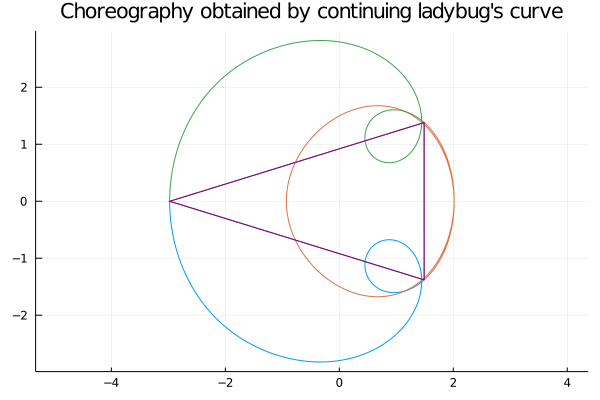

In [113]:
draw_z(zz[end], odef, p, 256, 2, 1, "Choreography obtained by continuing ladybug's curve", true)

# Automatize continuation

In [114]:
function farey_sequence(n::Int64)
    (a, b, c, d) = (0, 1, 1, n)
    frakzioak = [a//b]
    while c <= n
        k = div((n + b),d) 
        (a, b, c, d) = (c, d, k * c - a, k * d - b)
        push!(frakzioak, a//b)
    end
    return frakzioak
end

farey_sequence (generic function with 1 method)

In [171]:
D = 16
frakzioak = farey_sequence(D)[1:end-1] # azkenengo frakzioa, 1/1, ez dugu behar
angeluak = 2pi*frakzioak .- pi
# -pi angeluaz mugitu dugunez dena, frakzioak aldatuko ditugu lehentasunak lortzeko
frakzioak = frakzioak .- 1//2
lehentasunak = denominator.(frakzioak) .+ numerator.(frakzioak)/D
angeluak, lehentasunak

([-3.141592653589793, -2.748893571891069, -2.722713633111154, -2.6927937030769655, -2.658270706883671, -2.6179938779914944, -2.5703939893007397, -2.5132741228718345, -2.443460952792061, -2.356194490192345  …  2.3038346126325155, 2.356194490192345, 2.443460952792061, 2.5132741228718345, 2.5703939893007393, 2.617993877991494, 2.6582707068836715, 2.6927937030769655, 2.7227136331111543, 2.7488935718910685], [1.9375, 15.5625, 29.1875, 6.8125, 25.3125, 11.6875, 21.4375, 4.875, 17.5625, 7.8125  …  30.6875, 8.1875, 18.4375, 5.125, 22.5625, 12.3125, 26.6875, 7.1875, 30.8125, 16.4375])

In [172]:
# Figure-eight
z = [1.3914224855041892, -0.8888058233705901, 0.683796458425381, -0.14559734865585836, -0.6837964584253811, -0.14559734865585874, 5.372134247663828, 0.0, 8.709369406436208]

dbeta = -0.01

# z1 eta z2 lortu
z1 = z

f!.alpha .= 0
f!.alpha[8] = 1
f!.z0 .= z1
f!.z0[8] += dbeta

F = similar(z)
(f!(F, z),  norm(F))
print(F)

res = nlsolve(f!,z1,ftol=1e-8,method=:newton, iterations=10,show_trace=true)

z2 = res.zero
zz = [z1, z2]
# bilaketa egin
ukopmax = 300
iters0 = 2
iters1 = 4
maxiters = 6
lambda = abs(dbeta)
mu1 = 1.2
mu2 = 1.1
mu3 = 1.2
R = similar(z2)

i=0
cont = true

# beste kurben kandidatuen zerrenda
kandidatuak_denak = []

# angeluen zerrendan koreografiak duen beta non kokatzen den
# angeluak[bind] <= beta < angeluak[bind+1]
beta = ((z1[8] + pi) % 2pi) - pi

bind = length(angeluak)
for i in 2:length(angeluak)
    if beta < angeluak[i]
        bind = i-1
        break
    end
end

println(bind)
println(beta)
println(angeluak[bind])
        
# kurba honen ordezkarien kandidatuak
kand_orain = [fill(Inf, 9) for _ in 1:length(angeluak)]

berria_da = true

while cont
    i += 1 
    println(i)
    @. f!.alpha = zz[end] - zz[end-1]
    @. f!.alpha /= norm(f!.alpha)
    @. f!.z0 = zz[end] + f!.alpha * lambda
#    z00 = copy(f!.z0)
    z00 = zz[end]   
    res = nlsolve(f!,z00,ftol=1e-8,method=:newton, iterations=maxiters, show_trace=true)
    iters = res.iterations
    if converged(res)
        push!(zz, res.zero)
        println("T=", res.zero[7], ", beta=", res.zero[8],
                ", lambda=", lambda, ", it=", res.iterations, ", normres=", f!(R,res.zero))
        (iters <= iters0) ? lambda *=mu1 : nothing
        (iters >= iters1) ? lambda /=mu2  : nothing
        
        beta = ((res.zero[8] + pi) % 2pi) - pi
        
        """
        angelu_berria = false
        # begiratu ea angelua tartez aldatu den
        if beta < angeluak[bind]
            ind_berria = bind
            bind = bind-1 <= 0 ? length(angeluak) : bind-1
            angelu_berria = true
        elseif beta >= angeluak[(bind)%(length(angeluak))+1]
            bind = (bind)%(length(angeluak))+1
            angelu_berria = true
            ind_berria = bind
        end
        """
        
        angelu_berria = false
        if f!.alpha[8] < 0
            if bind == 1
                cond = beta > angeluak[end]
            else
                cond = beta < angeluak[bind]
            end
            if cond
                ind_berria = bind
                bind = bind-1 <= 0 ? length(angeluak) : bind-1
                angelu_berria = true
            end
        else
            if bind == length(angeluak)
                cond = beta < angeluak[2]
            else
                cond = beta > angeluak[bind+1]
            end
            if cond
                bind = (bind)%(length(angeluak))+1
                angelu_berria = true
                ind_berria = bind
            end
        end
        
        println("bind: ", bind)
        
        # aldatu bada, tartean piren zatitzailea daukagu. Kandidatu bat da
        if angelu_berria
            # lortu angeluari dagokion z
            f!.alpha .= 0
            f!.alpha[8] = 1
            f!.z0 .= res.zero
            # res.zero[8] > pi edo < -pi bada, angeluak listako balioengandik desberdina da
            # solve egiteko antzekoak izatea nahi dugu
            f!.z0[8] = angeluak[ind_berria] + 2pi*floor((res.zero[8]+pi)/(2pi))
            
            println("indb: ", ind_berria)
            println("beta: ", beta)
            println("bcmp: ", f!.z0[8])
            
            res = nlsolve(f!,res.zero,ftol=1e-8,method=:newton, iterations=10,show_trace=true)
            z_kand = res.zero
            
            # konparatu angelu horrekin aurkitutako besteekin. Existitzen bada, amaitu
            for bestea in kandidatuak_denak
                diff = bestea[ind_berria]-z_kand
                if dot(diff, diff) < 0.5
                    println("Dagoeneko aurkitu dugu!")
                    berria_da = false
                    break
                end
            end
            
            # periodorik laburrena duena hartuko dugu
            # hasieran Inf-ekin hasi dugula kontutan izan
            if z_kand[7] < kand_orain[ind_berria][7]
                println("Kandidatua!")
                println(z_kand[8])
                println(angeluak[ind_berria])
                kand_orain[ind_berria] = z_kand
            end
        end
        
    else
        lambda /= mu3
    end
    cont = berria_da && (i < ukopmax) && sign(zz[end][8])==sign(zz[end-1][8])
end
                
if berria_da
    push!(kandidatuak_denak, kand_orain)
end

kandidatuak_denak

[0.01, 3.672559493633357e-15, 5.773159728050814e-15, -8.881784197001252e-16, 2.4424906541753444e-15, -2.1094237467877974e-15, -1.4155343563970746e-15, 2.220446049250313e-16, 1.7763568394002505e-15]Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.000000e-02              NaN
     1     5.266863e-04     1.629299e-04
     2     4.609883e-08     2.132731e-09
     3     2.131628e-14     4.201281e-14
41
0.0
0.0
1
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     7.251872e-03     2.360439e-03
     2     7.203216e-06     5.469253e-07
     3     1.364931e-09     1.935585e-09
T=5.373044641994551, beta=-0.04782099284656661, lambda=0.01, it=3, normres=nothing
bind: 40
indb: 41
beta: -0.04782099284656649
bcmp: 0.0
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.782099e-02              NaN
     1     1.187007e-02     3.730517e-03
  

     3     7.722933e-12     1.172877e-11
T=5.501305010446833, beta=-0.5572298314006419, lambda=0.01, it=3, normres=nothing
bind: 33
17
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     2.477417e-03     1.846542e-03
     2     9.527989e-07     2.229693e-07
     3     5.882628e-12     8.992981e-12
T=5.516408337015167, beta=-0.5873526462311012, lambda=0.01, it=3, normres=nothing
bind: 33
18
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     2.438550e-03     1.830820e-03
     2     8.425482e-07     2.148476e-07
     3     4.518386e-12     6.984259e-12
T=5.532224372594134, beta=-0.616993620716587, lambda=0.01, it=3, normres=nothing
bind: 33
19
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     2.396969e-03     1.816844e-03
     2     7.458833e-07     

     0     9.000000e-02              NaN
     1     1.545751e-03     1.804918e-03
     2     1.406596e-07     1.767244e-07
     3     2.775558e-13     7.086962e-13
T=5.932001235248923, beta=-1.072682698882242, lambda=0.01, it=3, normres=nothing
bind: 27
37
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     1.495463e-03     1.817169e-03
     2     1.328812e-07     1.786378e-07
     3     2.606804e-13     6.835830e-13
T=5.960569880247769, beta=-1.0938595958312534, lambda=0.01, it=3, normres=nothing
bind: 27
38
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     1.445658e-03     1.831008e-03
     2     1.261463e-07     1.808553e-07
     3     2.398082e-13     6.612209e-13
T=5.989834118591386, beta=-1.1146149650631458, lambda=0.01, it=3, normres=nothing
bind: 27
39
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --

     1     1.132478e-03     2.466382e-03
     2     1.209226e-07     2.526913e-07
     3     8.881784e-15     1.163572e-13
T=6.6900904317167695, beta=-1.431287700916706, lambda=0.01, it=3, normres=nothing
bind: 22
indb: 23
beta: -1.431287700916706
bcmp: -1.4279966607226333
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.291040e-03              NaN
     1     7.622351e-05     1.634349e-04
     2     1.341717e-09     4.959801e-09
Kandidatua!
-1.4279966607226333
-1.4279966607226333
58
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     1.196252e-03     2.522903e-03
     2     1.211555e-07     2.558598e-07
     3     8.881784e-15     8.378376e-14
T=6.735216128564046, beta=-1.4440320034758423, lambda=0.01, it=3, normres=nothing
bind: 22
59
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1   

     2     7.747327e-07     2.143218e-07
     3     1.142197e-12     2.290733e-12
T=7.890440022062676, beta=-1.6347687143571736, lambda=0.01, it=3, normres=nothing
bind: 20
80
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     3.135023e-03     4.292076e-03
     2     8.249797e-07     2.076008e-07
     3     1.284306e-12     2.621435e-12
T=7.955041909743097, beta=-1.6407243602027652, lambda=0.01, it=3, normres=nothing
bind: 20
81
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     3.232052e-03     4.386154e-03
     2     8.760564e-07     2.006762e-07
     3     1.463718e-12     2.975884e-12
T=8.020445646804916, beta=-1.646449104393242, lambda=0.01, it=3, normres=nothing
bind: 20
82
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     3.328497e-03     

     0     9.000000e-02              NaN
     1     5.045354e-03     6.240035e-03
     2     2.037952e-06     6.221149e-08
     3     8.311574e-12     1.512173e-11
T=9.630369754338602, beta=-1.7273035296121115, lambda=0.01, it=3, normres=nothing
bind: 19
104
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     5.105221e-03     6.303241e-03
     2     2.086741e-06     5.429214e-08
     3     7.872814e-12     1.850083e-11
T=9.709772632796712, beta=-1.7294596030006781, lambda=0.01, it=3, normres=nothing
bind: 19
105
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     5.163644e-03     6.365081e-03
     2     2.131450e-06     5.092393e-08
     3     8.103740e-12     1.924203e-11
T=9.789573310680336, beta=-1.7315219821685688, lambda=0.01, it=3, normres=nothing
bind: 19
106
Iter     f(x) inf-norm    Step 2-norm 
------   -------------- 

     3     2.255263e-11     3.366601e-11
T=11.537200576891586, beta=-1.759006738666362, lambda=0.01, it=3, normres=nothing
bind: 18
127
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     6.089034e-03     7.353652e-03
     2     2.915273e-06     1.066537e-08
     3     2.307665e-11     3.424461e-11
T=11.623016169151837, beta=-1.7597777540045523, lambda=0.01, it=3, normres=nothing
bind: 18
128
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     6.117048e-03     7.383553e-03
     2     2.941400e-06     9.886805e-09
     3     2.375344e-11     3.481059e-11
T=11.709004720468597, beta=-1.7605149290010107, lambda=0.01, it=3, normres=nothing
bind: 18
129
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     6.144063e-03     7.412369e-03
     2     2.966735e-0

     0     9.000000e-02              NaN
     1     6.538650e-03     7.829855e-03
     2     3.354952e-06     1.694229e-09
     3     7.005063e-11     4.427604e-11
T=13.72161585692658, beta=-1.7708498162858608, lambda=0.01, it=3, normres=nothing
bind: 18
152
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     6.549644e-03     7.841356e-03
     2     3.366395e-06     1.570736e-09
     3     8.129941e-11     4.454343e-11
T=13.810195762507929, beta=-1.7711005427194615, lambda=0.01, it=3, normres=nothing
bind: 18
153
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     6.560193e-03     7.852383e-03
     2     3.377470e-06     1.457141e-09
     3     9.671108e-11     4.480755e-11
T=13.898836825539206, beta=-1.771340244628271, lambda=0.01, it=3, normres=nothing
bind: 18
154
Iter     f(x) inf-norm    Step 2-norm 
------   --------------

     3     1.845814e-09     4.847123e-11
T=15.860151025398693, beta=-1.7746137257058159, lambda=0.01, it=3, normres=nothing
bind: 18
176
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     6.712721e-03     8.010334e-03
     2     3.562242e-06     2.825384e-10
     3     2.129643e-09     4.851746e-11
T=15.94966152549201, beta=-1.7746989157014519, lambda=0.01, it=3, normres=nothing
bind: 18
177
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     6.716574e-03     8.014253e-03
     2     3.569756e-06     2.634146e-10
     3     2.451523e-09     4.863283e-11
T=16.039193403942964, beta=-1.774780358146378, lambda=0.01, it=3, normres=nothing
bind: 18
178
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     6.720269e-03     8.018003e-03
     2     3.577220e-06

     1     2.580221e-03     3.109411e-03
     2     7.074487e-07     3.440865e-12
     3     1.082098e-08     8.494528e-13
     4     3.814939e-10     2.804001e-17
T=17.765066356438187, beta=-1.7758055042873462, lambda=0.006209213230591549, it=4, normres=nothing
bind: 18
200
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.080265e-02              NaN
     1     2.129351e-03     2.570087e-03
     2     5.358787e-07     4.069762e-12
     3     9.762984e-09     3.534252e-13
T=17.815761244657658, beta=-1.7758241765526606, lambda=0.005644739300537772, it=3, normres=nothing
bind: 18
201
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.080265e-02              NaN
     1     2.129747e-03     2.570379e-03
     2     5.566473e-07     4.977183e-12
     3     1.129065e-08     3.409248e-13
     4     6.090763e-10     1.490429e-16
T=17.86645881771782, beta=-1.775842380598807, lambda=0.005644739300537772, it=4, no

     3     9.554179e-09     1.153411e-14
T=18.344769110241717, beta=-1.7759931333143326, lambda=0.001351305709310395, it=3, normres=nothing
bind: 18
221
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.216175e-02              NaN
     1     1.214367e-04     1.474600e-04
     2     1.468811e-07     2.482799e-12
     3     9.935951e-09     1.262691e-14
T=18.356911372934704, beta=-1.775996509059501, lambda=0.001351305709310395, it=3, normres=nothing
bind: 18
222
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.216175e-02              NaN
     1     1.214507e-04     1.474629e-04
     2     1.513319e-07     2.519447e-12
     3     1.046309e-08     1.093349e-14
     4     2.703927e-09     1.312138e-16
T=18.36905374791873, beta=-1.7759998643777255, lambda=0.001351305709310395, it=4, normres=nothing
bind: 18
223
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.105

     0     5.157770e-03              NaN
     1     2.211771e-05     2.653035e-05
     2     9.718696e-08     7.226309e-13
     3     8.674957e-09     5.451107e-15
T=18.52881660780485, beta=-1.7760421606179206, lambda=0.0005730855330116796, it=3, normres=nothing
bind: 18
244
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.157770e-03              NaN
     1     2.212333e-05     2.653058e-05
     2     9.923906e-08     7.740388e-13
     3     1.007009e-08     1.142447e-14
     4     2.148029e-09     1.026226e-15
T=18.533966809354418, beta=-1.7760434687029998, lambda=0.0005730855330116796, it=4, normres=nothing
bind: 18
245
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.688882e-03              NaN
     1     1.832516e-05     2.192644e-05
     2     9.156491e-08     6.484239e-13
     3     8.949072e-09     6.954642e-15
T=18.538648853416806, beta=-1.7760446546523838, lambda=0.000520986848192436, it=3,

     0     3.522826e-03              NaN
     1     1.046084e-05     1.237871e-05
     2     8.684252e-08     4.459627e-13
     3     9.560840e-09     5.881972e-15
T=18.62588670016087, beta=-1.7760662523579778, lambda=0.00039142513012204046, it=3, normres=nothing
bind: 18
267
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.522826e-03              NaN
     1     1.046101e-05     1.237873e-05
     2     8.720406e-08     4.356662e-13
     3     9.279977e-09     4.650432e-15
T=18.629404613607466, beta=-1.7760671035859472, lambda=0.00039142513012204046, it=3, normres=nothing
bind: 18
268
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.522826e-03              NaN
     1     1.046518e-05     1.237885e-05
     2     8.922186e-08     4.680844e-13
     3     9.588092e-09     5.015974e-15
T=18.632922526495356, beta=-1.7760679534544948, lambda=0.00039142513012204046, it=3, normres=nothing
bind: 18
269
Iter   

     0     2.406138e-03              NaN
     1     4.982668e-06     5.775461e-06
     2     7.211471e-08     2.584834e-13
     3     9.327386e-09     5.461128e-15
T=18.69345294334132, beta=-1.7760823424096208, lambda=0.0002673486306413772, it=3, normres=nothing
bind: 18
290
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.406138e-03              NaN
     1     4.982305e-06     5.775381e-06
     2     7.254778e-08     2.583867e-13
     3     8.582132e-09     3.371344e-15
T=18.695855817465716, beta=-1.776082904901144, lambda=0.0002673486306413772, it=3, normres=nothing
bind: 18
291
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.406138e-03              NaN
     1     4.981822e-06     5.775447e-06
     2     7.229992e-08     2.459785e-13
     3     8.896302e-09     2.989624e-15
T=18.69825871270679, beta=-1.7760834664645924, lambda=0.0002673486306413772, it=3, normres=nothing
bind: 18
292
Iter     f(x

1-element Array{Any,1}:
 [[Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf]  …  [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf]]

In [173]:
kandidatuak = kandidatuak_denak[1]
koreografiak = [kor for kor in kandidatuak if kor[1] != Inf]
length(koreografiak)

23

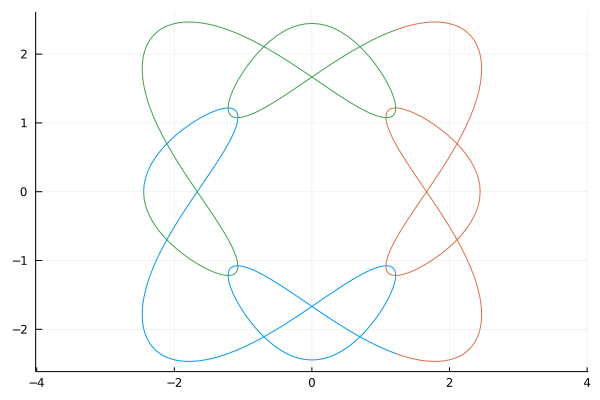

In [192]:
draw_z(koreografiak[3], odef, p, 256, 2, 4)

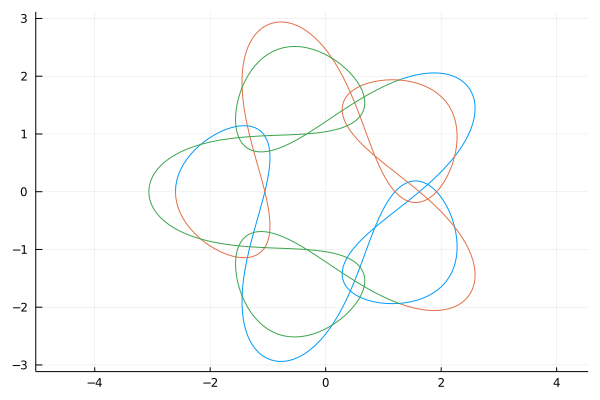

In [193]:
draw_z(koreografiak[7], odef, p, 256, 2, 5)